# 03__TF_expr

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def is_sig(row):
    if row.padj < 0.01 and np.abs(row.log2FoldChange) >= 1:
        return "sig"
    else:
        return "not sig"

## variables

In [5]:
hESC_expr_f = "../../../data/03__rna_seq/03__diff_expr/hESC.tpm.txt"
mESC_expr_f = "../../../data/03__rna_seq/03__diff_expr/mESC.tpm.txt"
orth_expr_f = "../../../data/03__rna_seq/03__diff_expr/orth.tpm.txt"
orth_de_f = "../../../data/03__rna_seq/03__diff_expr/orth.DESeq2.txt"

In [6]:
orth_f = "../../../misc/00__ensembl_orthologs/ensembl96_human_mouse_orths.txt.gz"
human_gene_map_f = "../../../misc/00__ensembl_orthologs/gencode.v25lift37.GENE_ID_TO_NAME_AND_BIOTYPE_MAP.txt"
mouse_gene_map_f = "../../../misc/00__ensembl_orthologs/gencode.vM13.GENE_ID_TO_NAME_AND_BIOTYPE_MAP.txt"

In [7]:
motif_info_dir = "../../../misc/01__motif_info"
motif_map_f = "%s/00__lambert_et_al_files/00__metadata/curated_motif_map.txt" % motif_info_dir
motif_info_f = "%s/00__lambert_et_al_files/00__metadata/motif_info.txt" % motif_info_dir

## 1. import data

In [8]:
hESC_expr = pd.read_table(hESC_expr_f).reset_index()
mESC_expr = pd.read_table(mESC_expr_f).reset_index()
hESC_expr.head()

,index,rep1,rep2
0,ENSG00000223972,1.779395,0.000000
1,ENSG00000227232,40.036384,40.463195
2,ENSG00000243485,2.669092,0.000000
3,ENSG00000237613,0.000000,0.000000
4,ENSG00000268020,0.000000,0.000000


In [9]:
orth_expr = pd.read_table(orth_expr_f).reset_index()
orth_expr.head()

,index,hESC_rep1,hESC_rep2,mESC_rep1,mESC_rep2,mESC_rep3
0,ENSG00000187634__ENSMUSG00000096351,83.679350,79.231477,5.435120,5.175746,8.009315
1,ENSG00000188976__ENSMUSG00000095567,6687.911089,5203.261186,14972.669086,14729.139239,15010.256691
2,ENSG00000187961__ENSMUSG00000078485,896.564459,824.243874,714.174792,777.397116,744.065336
3,ENSG00000187642__ENSMUSG00000078486,10.115086,4.730237,30.436673,22.773284,16.018629
4,ENSG00000187608__ENSMUSG00000035692,502.076097,572.358731,6.522144,5.175746,4.004657


In [10]:
orth_de = pd.read_table(orth_de_f).reset_index()
orth_de.head()

,index,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000187634__ENSMUSG00000096351,36.306202,3.692209,0.558543,6.610430,3.832054e-11,7.549767e-11
1,ENSG00000188976__ENSMUSG00000095567,11320.647458,-1.325181,0.103735,-12.774677,2.270873e-37,8.353734e-37
2,ENSG00000187961__ENSMUSG00000078485,791.289116,0.208486,0.112457,1.853912,6.375168e-02,7.966884e-02
3,ENSG00000187642__ENSMUSG00000078486,16.814782,-1.606687,0.778087,-2.064918,3.893073e-02,4.967260e-02
4,ENSG00000187608__ENSMUSG00000035692,218.027475,6.712128,0.420436,15.964673,2.252187e-57,1.128198e-56


In [11]:
orth = pd.read_table(orth_f)
orth.head()

,Gene stable ID,Transcript stable ID,Gene name,Mouse gene stable ID,Mouse protein or transcript stable ID,Mouse gene name,%id. target Mouse gene identical to query gene,%id. query gene identical to target Mouse gene,"Mouse orthology confidence [0 low, 1 high]",Mouse homology type
0,ENSG00000198888,ENST00000361390,MT-ND1,ENSMUSG00000064341,ENSMUSP00000080991,mt-Nd1,77.0440,77.0440,1.0,ortholog_one2one
1,ENSG00000198763,ENST00000361453,MT-ND2,ENSMUSG00000064345,ENSMUSP00000080992,mt-Nd2,57.0605,57.3913,1.0,ortholog_one2one
2,ENSG00000198804,ENST00000361624,MT-CO1,ENSMUSG00000064351,ENSMUSP00000080993,mt-Co1,90.8382,90.6615,1.0,ortholog_one2one
3,ENSG00000198712,ENST00000361739,MT-CO2,ENSMUSG00000064354,ENSMUSP00000080994,mt-Co2,71.3656,71.3656,1.0,ortholog_one2one
4,ENSG00000228253,ENST00000361851,MT-ATP8,ENSMUSG00000064356,ENSMUSP00000080995,mt-Atp8,45.5882,46.2687,0.0,ortholog_one2one


In [12]:
human_gene_map = pd.read_table(human_gene_map_f, header=None)
human_gene_map.columns = ["gene_id", "biotype", "gene_name"]
human_gene_map.head()

,gene_id,biotype,gene_name
0,ENSG00000223972.5_1,transcribed_unprocessed_pseudogene,DDX11L1
1,ENSG00000227232.5_1,unprocessed_pseudogene,WASH7P
2,ENSG00000243485.4_2,lincRNA,MIR1302-2
3,ENSG00000237613.2_1,lincRNA,FAM138A
4,ENSG00000268020.3_1,unprocessed_pseudogene,OR4G4P


In [13]:
mouse_gene_map = pd.read_table(mouse_gene_map_f, header=None)
mouse_gene_map.columns = ["gene_id", "biotype", "gene_name"]
mouse_gene_map.head()

,gene_id,biotype,gene_name
0,ENSMUSG00000102693.1,TEC,4933401J01Rik
1,ENSMUSG00000064842.1,snRNA,Gm26206
2,ENSMUSG00000051951.5,protein_coding,Xkr4
3,ENSMUSG00000102851.1,processed_pseudogene,Gm18956
4,ENSMUSG00000103377.1,TEC,Gm37180


In [14]:
motif_info = pd.read_table(motif_info_f)
motif_info.head()

,Ensembl ID,HGNC symbol,Motif evidence,Motif ID,Motif type,Motif source,CIS-BP ID,Best Motif(s)? (Figure 2A)
0,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_HT-SELEX,HT-SELEX,Yin2017,M08490_1.94d,True
1,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M08491_1.94d,NaN
2,ENSG00000267281,AC023509.3,"Inferred - Atf7 (98% AA Identity, Mus musculus)",3T3L1-Atf7_GSE56872,Misc,HOMER,M06975_1.94d,NaN
3,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_HT-SELEX,HT-SELEX,Yin2017,M09315_1.94d,True
4,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M09316_1.94d,NaN


In [15]:
motif_info["short_id"] = motif_info["CIS-BP ID"].str.split(".", expand=True)[0]
motif_info = motif_info[motif_info["Best Motif(s)? (Figure 2A)"] == True]
motif_map = motif_info[["short_id","Ensembl ID", "HGNC symbol"]]
motif_map.columns = ["index", "gene_id", "gene_name"]
motif_map = motif_map.sort_values(by="index")
print(len(motif_map))
motif_map.head()

1496


,index,gene_id,gene_name
8042,HKR1,ENSG00000181666,HKR1
590,M00140_1,ENSG00000179361,ARID3B
603,M00142_1,ENSG00000205143,ARID3C
574,M00142_1,ENSG00000116017,ARID3A
619,M00143_1,ENSG00000150347,ARID5B


In [16]:
motif_map[motif_map["gene_name"] == "ASCL2"]

,index,gene_id,gene_name
906,M08476_1,ENSG00000183734,ASCL2


## 2. do some QC on RNA-seq

In [18]:
human_gene_map["index"] = human_gene_map["gene_id"].str.split(".", expand=True)[0]
mouse_gene_map["index"] = mouse_gene_map["gene_id"].str.split(".", expand=True)[0]
mouse_gene_map.head()

,gene_id,biotype,gene_name,index
0,ENSMUSG00000102693.1,TEC,4933401J01Rik,ENSMUSG00000102693
1,ENSMUSG00000064842.1,snRNA,Gm26206,ENSMUSG00000064842
2,ENSMUSG00000051951.5,protein_coding,Xkr4,ENSMUSG00000051951
3,ENSMUSG00000102851.1,processed_pseudogene,Gm18956,ENSMUSG00000102851
4,ENSMUSG00000103377.1,TEC,Gm37180,ENSMUSG00000103377


In [19]:
hESC_expr = hESC_expr.merge(human_gene_map, on="index", how="left")
hESC_expr.sample(5)

,index,rep1,rep2,gene_id,biotype,gene_name
21266,ENSG00000205186,0.000000,0.000000,ENSG00000205186.2_1,protein_coding,FABP9
41539,ENSG00000263393,13.345461,7.867843,ENSG00000263393.1_1,antisense,RP11-53I6.4
26802,ENSG00000175220,3298.108308,2636.851549,ENSG00000175220.11_2,protein_coding,ARHGAP1
6469,ENSG00000233729,1.779395,5.619888,ENSG00000233729.1_1,antisense,AC016909.1
28811,ENSG00000177406,82.741859,127.009474,ENSG00000177406.4_1,antisense,RP11-218M22.1


In [20]:
mESC_expr = mESC_expr.merge(mouse_gene_map, on="index", how="left")
mESC_expr.sample(5)

,index,rep1,rep2,rep3,gene_id,biotype,gene_name
47873,ENSMUSG00000015665,0.000000,0.000000,0.000000,ENSMUSG00000015665.8,protein_coding,Awat1
15110,ENSMUSG00000054675,8.998718,4.281684,0.827301,ENSMUSG00000054675.5,protein_coding,Tmem119
4765,ENSMUSG00000049044,47.243272,57.802735,71.975186,ENSMUSG00000049044.16,protein_coding,Rapgef4
11958,ENSMUSG00000054958,2.249680,2.140842,1.654602,ENSMUSG00000054958.6,protein_coding,Nt5c1a
13921,ENSMUSG00000106292,0.000000,0.000000,0.000000,ENSMUSG00000106292.1,TEC,Gm43174


In [21]:
human_genes_to_check = ["XIST", "SRY", "RPS4Y1", "DDX3Y", "POU5F1", "NANOG", "SOX2", "EOMES", "SOX17", "FOXA2"]

In [22]:
human_sub = hESC_expr[hESC_expr["gene_name"].isin(human_genes_to_check)]
human_sub = pd.melt(human_sub[["gene_name", "rep1", "rep2"]], id_vars="gene_name")
human_sub.head()

,gene_name,variable,value
0,EOMES,rep1,2110.362262
1,SOX2,rep1,15816.150901
2,POU5F1,rep1,48615.735710
3,SOX17,rep1,505.348130
4,NANOG,rep1,5629.115529


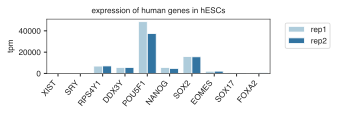

In [23]:
fig = plt.figure(figsize=(4, 1))

ax = sns.barplot(data=human_sub, x="gene_name", y="value", hue="variable", palette="Paired", 
                 order=human_genes_to_check)
#ax.set_yscale('symlog')
ax.set_xticklabels(human_genes_to_check, va="top", ha="right", rotation=50)
ax.set_ylabel("tpm")
ax.set_title("expression of human genes in hESCs")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

In [24]:
mouse_genes_to_check = ["Xist", "Sry", "Eif2s3y", "Ddx3y", "Pou5f1", "Nanog", "Sox2", "Eomes", "Sox17", "Foxa2"]

In [25]:
mouse_sub = mESC_expr[mESC_expr["gene_name"].isin(mouse_genes_to_check)]
mouse_sub = pd.melt(mouse_sub[["gene_name", "rep1", "rep2", "rep3"]], id_vars="gene_name")
mouse_sub.head()

,gene_name,variable,value
0,Sox17,rep1,15.747757
1,Foxa2,rep1,11.248398
2,Sox2,rep1,26213.266644
3,Nanog,rep1,46427.762648
4,Eomes,rep1,557.920540


In [26]:
mouse_sub.gene_name.unique()

array(['Sox17', 'Foxa2', 'Sox2', 'Nanog', 'Eomes', 'Pou5f1', 'Xist',
       'Eif2s3y', 'Ddx3y', 'Sry'], dtype=object)

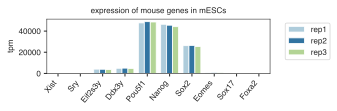

In [27]:
fig = plt.figure(figsize=(4, 1))

ax = sns.barplot(data=mouse_sub, x="gene_name", y="value", hue="variable", palette="Paired", 
                 order=mouse_genes_to_check)
#ax.set_yscale('symlog')
ax.set_xticklabels(mouse_genes_to_check, va="top", ha="right", rotation=50)
ax.set_ylabel("tpm")
ax.set_title("expression of mouse genes in mESCs")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

## 3. look at expression of TFs in hESCs

In [28]:
uniq_human_TFs = motif_map["gene_name"].unique()
print(len(uniq_human_TFs))

TFs_in_seq = [x for x in uniq_human_TFs if x in list(hESC_expr["gene_name"])]
print(len(TFs_in_seq))

TFs_missing = [x for x in uniq_human_TFs if x not in list(hESC_expr["gene_name"])]
print(len(TFs_missing))

1208
1201
7


In [29]:
TFs_missing

['DUX4', 'DUX1', 'DUX3', 'ZNF883', 'AC023509.3', 'AC138696.1', 'ZSCAN5C']

the above TFs are missing from the RNA-seq so will not be included (I hand checked a few and couldn't find easy aliases, might look more later)

In [30]:
hESC_TFs = hESC_expr[hESC_expr["gene_name"].isin(uniq_human_TFs)].drop_duplicates(subset=["index", "rep1", "rep2",
                                                                                          "biotype", "gene_name"])
print(len(hESC_TFs))
hESC_TFs.head()

1203


,index,rep1,rep2,gene_id,biotype,gene_name
59,ENSG00000188290,124.557638,198.944043,ENSG00000188290.10_1,protein_coding,HES4
146,ENSG00000197921,81.852162,121.389585,ENSG00000197921.5_1,protein_coding,HES5
161,ENSG00000142611,75.624280,178.712445,ENSG00000142611.16_2,protein_coding,PRDM16
171,ENSG00000078900,82.741859,127.009474,ENSG00000078900.14_2,protein_coding,TP73
202,ENSG00000173673,1333.656421,1188.044368,ENSG00000173673.7_1,protein_coding,HES3


In [31]:
tmp = hESC_TFs.groupby("gene_name")["index"].agg("count").reset_index()
tmp.sort_values(by="index", ascending=False).head()

,gene_name,index
1170,ZNF8,2
1133,ZNF727,2
0,AHR,1
798,UBP1,1
804,VDR,1


one of these TFs have multiple gene_ids (probably from using the lifted gencode v25 instead of gencode v25 in hg38). manually fix this guy

In [32]:
hESC_TFs = hESC_TFs[hESC_TFs["index"] != "ENSG00000273439"]
len(hESC_TFs)

1202

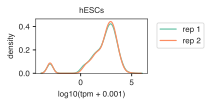

In [33]:
fig = plt.figure(figsize=(2, 1))

ax = sns.distplot(np.log10(hESC_TFs["rep1"]+0.001), label="rep 1", color=sns.color_palette("Set2")[0], hist=False)
sns.distplot(np.log10(hESC_TFs["rep2"]+0.001), label="rep 2", color=sns.color_palette("Set2")[1], hist=False)

ax.set_xlabel("log10(tpm + 0.001)")
ax.set_ylabel("density")
ax.set_title("hESCs")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

In [34]:
hESC_TFs["mean_tpm"] = hESC_TFs[["rep1", "rep2"]].mean(axis=1)
hESC_TFs.head()

,index,rep1,rep2,gene_id,biotype,gene_name,mean_tpm
59,ENSG00000188290,124.557638,198.944043,ENSG00000188290.10_1,protein_coding,HES4,161.750840
146,ENSG00000197921,81.852162,121.389585,ENSG00000197921.5_1,protein_coding,HES5,101.620874
161,ENSG00000142611,75.624280,178.712445,ENSG00000142611.16_2,protein_coding,PRDM16,127.168363
171,ENSG00000078900,82.741859,127.009474,ENSG00000078900.14_2,protein_coding,TP73,104.875666
202,ENSG00000173673,1333.656421,1188.044368,ENSG00000173673.7_1,protein_coding,HES3,1260.850395


In [35]:
hESC_TFs_expr = list(hESC_TFs[hESC_TFs["mean_tpm"] > 1]["gene_name"])
len(hESC_TFs_expr)

1136

## 4. look at expression of orthologous TFs in mouse

In [36]:
human_mouse_TFs = hESC_TFs[["index", "gene_name", "mean_tpm"]]
print(len(human_mouse_TFs))
human_mouse_TFs = human_mouse_TFs.merge(orth[["Gene stable ID", 
                                              "Mouse gene stable ID", 
                                              "Gene name",
                                              "Mouse gene name"]].drop_duplicates(),
                                        left_on=["index", "gene_name"],
                                        right_on=["Gene stable ID", "Gene name"])
human_mouse_TFs.drop(["Gene stable ID", "Gene name"], axis=1, inplace=True)
human_mouse_TFs.columns = ["gene_id_human", "gene_name_human", "mean_tpm_human", "gene_id_mouse", "gene_name_mouse"]
print(len(human_mouse_TFs))
human_mouse_TFs.head()

1202
1092


,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse
0,ENSG00000197921,HES5,101.620874,ENSMUSG00000048001,Hes5
1,ENSG00000142611,PRDM16,127.168363,ENSMUSG00000039410,Prdm16
2,ENSG00000078900,TP73,104.875666,ENSMUSG00000029026,Trp73
3,ENSG00000173673,HES3,1260.850395,ENSMUSG00000028946,Hes3
4,ENSG00000069812,HES2,30.322266,ENSMUSG00000028940,Hes2


In [37]:
mESC_expr["mean_tpm_mouse"] = mESC_expr[["rep1", "rep2", "rep3"]].mean(axis=1)
mESC_expr.head()

,index,rep1,rep2,rep3,gene_id,biotype,gene_name,mean_tpm_mouse
0,ENSMUSG00000102693,0.00000,0.000000,0.000000,ENSMUSG00000102693.1,TEC,4933401J01Rik,0.000000
1,ENSMUSG00000064842,0.00000,0.000000,0.000000,ENSMUSG00000064842.1,snRNA,Gm26206,0.000000
2,ENSMUSG00000051951,2.24968,2.140842,1.654602,ENSMUSG00000051951.5,protein_coding,Xkr4,2.015041
3,ENSMUSG00000102851,0.00000,0.000000,0.000000,ENSMUSG00000102851.1,processed_pseudogene,Gm18956,0.000000
4,ENSMUSG00000103377,0.00000,0.000000,0.000000,ENSMUSG00000103377.1,TEC,Gm37180,0.000000


In [38]:
human_mouse_TFs = human_mouse_TFs.merge(mESC_expr[["index", "gene_name", "mean_tpm_mouse"]],
                                        left_on=["gene_id_mouse", "gene_name_mouse"],
                                        right_on=["index", "gene_name"])
human_mouse_TFs.drop(["index", "gene_name"], axis=1, inplace=True)
print(len(human_mouse_TFs))
human_mouse_TFs.head()

1082


,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse
0,ENSG00000197921,HES5,101.620874,ENSMUSG00000048001,Hes5,0.000000
1,ENSG00000142611,PRDM16,127.168363,ENSMUSG00000039410,Prdm16,1160.183127
2,ENSG00000078900,TP73,104.875666,ENSMUSG00000029026,Trp73,1094.785279
3,ENSG00000173673,HES3,1260.850395,ENSMUSG00000028946,Hes3,6.791385
4,ENSG00000069812,HES2,30.322266,ENSMUSG00000028940,Hes2,11.737072


In [39]:
human_mouse_TFs[human_mouse_TFs["gene_name_mouse"] == "Zfy2"]

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse
871,ENSG00000171469,ZNF561,3987.922328,ENSMUSG00000000103,Zfy2,1.265148
872,ENSG00000171466,ZNF562,3040.170436,ENSMUSG00000000103,Zfy2,1.265148
873,ENSG00000180884,ZNF792,460.704776,ENSMUSG00000000103,Zfy2,1.265148
874,ENSG00000188227,ZNF793,787.993852,ENSMUSG00000000103,Zfy2,1.265148
875,ENSG00000198464,ZNF480,2779.515238,ENSMUSG00000000103,Zfy2,1.265148
876,ENSG00000167554,ZNF610,191.792821,ENSMUSG00000000103,Zfy2,1.265148
877,ENSG00000131845,ZNF304,800.405029,ENSMUSG00000000103,Zfy2,1.265148
878,ENSG00000188785,ZNF548,510.935187,ENSMUSG00000000103,Zfy2,1.265148
879,ENSG00000105136,ZNF419,462.300151,ENSMUSG00000000103,Zfy2,1.265148
880,ENSG00000121406,ZNF549,850.420616,ENSMUSG00000000103,Zfy2,1.265148


In [40]:
mESC_TFs_expr = list(human_mouse_TFs[human_mouse_TFs["mean_tpm_mouse"] > 1]["gene_name_mouse"].unique())
len(mESC_TFs_expr)

905

## 5. look at orthologous expression

In [41]:
orth_expr["gene_id_human"] = orth_expr["index"].str.split("__", expand=True)[0]
orth_expr["gene_id_mouse"] = orth_expr["index"].str.split("__", expand=True)[1]
orth_expr.head()

,index,hESC_rep1,hESC_rep2,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse
0,ENSG00000187634__ENSMUSG00000096351,83.679350,79.231477,5.435120,5.175746,8.009315,ENSG00000187634,ENSMUSG00000096351
1,ENSG00000188976__ENSMUSG00000095567,6687.911089,5203.261186,14972.669086,14729.139239,15010.256691,ENSG00000188976,ENSMUSG00000095567
2,ENSG00000187961__ENSMUSG00000078485,896.564459,824.243874,714.174792,777.397116,744.065336,ENSG00000187961,ENSMUSG00000078485
3,ENSG00000187642__ENSMUSG00000078486,10.115086,4.730237,30.436673,22.773284,16.018629,ENSG00000187642,ENSMUSG00000078486
4,ENSG00000187608__ENSMUSG00000035692,502.076097,572.358731,6.522144,5.175746,4.004657,ENSG00000187608,ENSMUSG00000035692


In [42]:
orth_sub = orth[["Gene stable ID", "Mouse gene stable ID", "Gene name", "Mouse gene name"]].drop_duplicates()
orth_sub.columns = ["gene_id_human", "gene_id_mouse", "gene_name_human", "gene_name_mouse"]
orth_expr = orth_expr.merge(orth_sub, on=["gene_id_human", "gene_id_mouse"]).drop_duplicates()
orth_expr.head()

,index,hESC_rep1,hESC_rep2,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse,gene_name_human,gene_name_mouse
0,ENSG00000187634__ENSMUSG00000096351,83.679350,79.231477,5.435120,5.175746,8.009315,ENSG00000187634,ENSMUSG00000096351,SAMD11,Samd11
1,ENSG00000188976__ENSMUSG00000095567,6687.911089,5203.261186,14972.669086,14729.139239,15010.256691,ENSG00000188976,ENSMUSG00000095567,NOC2L,Noc2l
2,ENSG00000187961__ENSMUSG00000078485,896.564459,824.243874,714.174792,777.397116,744.065336,ENSG00000187961,ENSMUSG00000078485,KLHL17,Plekhn1
3,ENSG00000187642__ENSMUSG00000078486,10.115086,4.730237,30.436673,22.773284,16.018629,ENSG00000187642,ENSMUSG00000078486,PERM1,Perm1
4,ENSG00000187608__ENSMUSG00000035692,502.076097,572.358731,6.522144,5.175746,4.004657,ENSG00000187608,ENSMUSG00000035692,ISG15,Isg15


In [43]:
orth_expr["mean_tpm_hESC"] = orth_expr[["hESC_rep1", "hESC_rep2"]].mean(axis=1)
orth_expr["mean_tpm_mESC"] = orth_expr[["mESC_rep1", "mESC_rep2", "mESC_rep3"]].mean(axis=1)
orth_expr.head()

,index,hESC_rep1,hESC_rep2,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse,gene_name_human,gene_name_mouse,mean_tpm_hESC,mean_tpm_mESC
0,ENSG00000187634__ENSMUSG00000096351,83.679350,79.231477,5.435120,5.175746,8.009315,ENSG00000187634,ENSMUSG00000096351,SAMD11,Samd11,81.455413,6.206727
1,ENSG00000188976__ENSMUSG00000095567,6687.911089,5203.261186,14972.669086,14729.139239,15010.256691,ENSG00000188976,ENSMUSG00000095567,NOC2L,Noc2l,5945.586138,14904.021672
2,ENSG00000187961__ENSMUSG00000078485,896.564459,824.243874,714.174792,777.397116,744.065336,ENSG00000187961,ENSMUSG00000078485,KLHL17,Plekhn1,860.404167,745.212415
3,ENSG00000187642__ENSMUSG00000078486,10.115086,4.730237,30.436673,22.773284,16.018629,ENSG00000187642,ENSMUSG00000078486,PERM1,Perm1,7.422662,23.076196
4,ENSG00000187608__ENSMUSG00000035692,502.076097,572.358731,6.522144,5.175746,4.004657,ENSG00000187608,ENSMUSG00000035692,ISG15,Isg15,537.217414,5.234183


In [44]:
orth_expr = orth_expr.merge(orth_de, on="index")
orth_expr.head()

,index,hESC_rep1,hESC_rep2,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse,gene_name_human,gene_name_mouse,mean_tpm_hESC,mean_tpm_mESC,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000187634__ENSMUSG00000096351,83.679350,79.231477,5.435120,5.175746,8.009315,ENSG00000187634,ENSMUSG00000096351,SAMD11,Samd11,81.455413,6.206727,36.306202,3.692209,0.558543,6.610430,3.832054e-11,7.549767e-11
1,ENSG00000188976__ENSMUSG00000095567,6687.911089,5203.261186,14972.669086,14729.139239,15010.256691,ENSG00000188976,ENSMUSG00000095567,NOC2L,Noc2l,5945.586138,14904.021672,11320.647458,-1.325181,0.103735,-12.774677,2.270873e-37,8.353734e-37
2,ENSG00000187961__ENSMUSG00000078485,896.564459,824.243874,714.174792,777.397116,744.065336,ENSG00000187961,ENSMUSG00000078485,KLHL17,Plekhn1,860.404167,745.212415,791.289116,0.208486,0.112457,1.853912,6.375168e-02,7.966884e-02
3,ENSG00000187642__ENSMUSG00000078486,10.115086,4.730237,30.436673,22.773284,16.018629,ENSG00000187642,ENSMUSG00000078486,PERM1,Perm1,7.422662,23.076196,16.814782,-1.606687,0.778087,-2.064918,3.893073e-02,4.967260e-02
4,ENSG00000187608__ENSMUSG00000035692,502.076097,572.358731,6.522144,5.175746,4.004657,ENSG00000187608,ENSMUSG00000035692,ISG15,Isg15,537.217414,5.234183,218.027475,6.712128,0.420436,15.964673,2.252187e-57,1.128198e-56


In [45]:
orth_expr["sig"] = orth_expr.apply(is_sig, axis=1)
orth_expr.sig.value_counts()

not sig    10216
sig         9642
Name: sig, dtype: int64

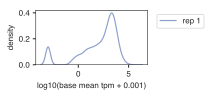

In [46]:
fig = plt.figure(figsize=(2, 1))

ax = sns.distplot(np.log10(orth_expr["baseMean"]+0.001), label="rep 1", color=sns.color_palette("Set2")[2], hist=False)

ax.set_xlabel("log10(base mean tpm + 0.001)")
ax.set_ylabel("density")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

In [47]:
orth_expr_filt = orth_expr[orth_expr["baseMean"] >= 1]
len(orth_expr_filt)

17346

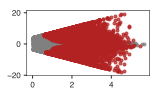

In [48]:
fig, ax = plt.subplots(figsize=(2.2, 1.2), nrows=1, ncols=1)

ax.scatter(np.log10(orth_expr_filt[orth_expr_filt["sig"] == "not sig"]["baseMean"]+0.001), 
           orth_expr_filt[orth_expr_filt["sig"] == "not sig"]["log2FoldChange"],
           color="gray", alpha=0.75, s=10, rasterized=True)
ax.scatter(np.log10(orth_expr_filt[orth_expr_filt["sig"] == "sig"]["baseMean"]+0.001), 
           orth_expr_filt[orth_expr_filt["sig"] == "sig"]["log2FoldChange"],
           color="firebrick", alpha=0.75, s=10, rasterized=True)

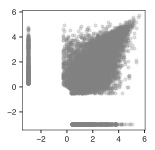

In [49]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(np.log10(orth_expr_filt["mean_tpm_hESC"]+0.001), 
           np.log10(orth_expr_filt["mean_tpm_mESC"]+0.001),
           color="gray", alpha=0.25, s=10, rasterized=True)

In [50]:
orth_tf_expr = human_mouse_TFs.merge(orth_expr, on=["gene_id_human", "gene_name_human", 
                                                    "gene_id_mouse", "gene_name_mouse"]).drop_duplicates()
print(len(orth_tf_expr))
orth_tf_expr.head()

995


,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,index,hESC_rep1,hESC_rep2,mESC_rep1,...,mESC_rep3,mean_tpm_hESC,mean_tpm_mESC,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sig
0,ENSG00000197921,HES5,101.620874,ENSMUSG00000048001,Hes5,0.000000,ENSG00000197921__ENSMUSG00000048001,84.598903,127.716411,0.000000,...,0.000000,106.157657,0.000000,42.463063,9.220488,1.288307,7.157056,8.242812e-13,1.707594e-12,sig
1,ENSG00000142611,PRDM16,127.168363,ENSMUSG00000039410,Prdm16,1160.183127,ENSG00000142611__ENSMUSG00000039410,78.162030,188.026938,1079.414869,...,1219.818630,133.094484,1122.157472,726.532277,-3.087431,0.291775,-10.581561,3.628622e-26,1.049818e-25,sig
2,ENSG00000078900,TP73,104.875666,ENSMUSG00000029026,Trp73,1094.785279,ENSG00000078900__ENSMUSG00000029026,85.518456,133.629208,998.975090,...,1087.664937,109.573832,1058.884076,679.159979,-3.288922,0.188538,-17.444302,3.803342e-68,2.171432e-67,sig
3,ENSG00000173673,HES3,1260.850395,ENSMUSG00000028946,Hes3,6.791385,ENSG00000173673__ENSMUSG00000028946,1378.410384,1249.965244,6.522144,...,8.009315,1314.187814,6.569068,529.616567,7.618832,0.348308,21.873866,4.608271e-106,4.031740e-105,sig
4,ENSG00000069812,HES2,30.322266,ENSMUSG00000028940,Hes2,11.737072,ENSG00000069812__ENSMUSG00000028940,26.667045,36.659340,15.218337,...,6.407452,31.663193,11.349193,19.474793,1.493640,0.690207,2.164048,3.046069e-02,3.923633e-02,not sig


In [51]:
orth_tf_expr = orth_tf_expr[["gene_id_human", "gene_name_human", "mean_tpm_human", "gene_id_mouse", "gene_name_mouse",
                             "mean_tpm_mouse", "baseMean", "log2FoldChange", "lfcSE", "padj", "sig"]].drop_duplicates()
len(orth_tf_expr)

995

In [52]:
# remove any orth pair that maps to more than one gene
tmp = orth_tf_expr.groupby("gene_name_human")["gene_name_mouse"].agg("count").reset_index()
human_dupe_orths = tmp[tmp["gene_name_mouse"] > 1]
print(len(human_dupe_orths))
human_dupe_orths

12


,gene_name_human,gene_name_mouse
188,FOXG1,2
433,MTERF1,2
444,MYCN,2
782,ZBED6,2
867,ZNF274,2
879,ZNF34,27
893,ZNF433,2
905,ZNF519,5
907,ZNF524,2
911,ZNF566,2


In [53]:
# remove any orth pair that maps to more than one gene
tmp = orth_tf_expr.groupby("gene_name_mouse")["gene_name_human"].agg("count").reset_index()
mouse_dupe_orths = tmp[tmp["gene_name_human"] > 1]
print(len(mouse_dupe_orths))
mouse_dupe_orths.head()

8


,gene_name_mouse,gene_name_human
178,Foxd4,5
333,Hsfy2,2
414,Mef2b,2
460,Nanog,2
583,Pou5f1,2


In [54]:
orth_tf_expr = orth_tf_expr[~orth_tf_expr["gene_name_human"].isin(human_dupe_orths["gene_name_human"])]
orth_tf_expr = orth_tf_expr[~orth_tf_expr["gene_name_mouse"].isin(mouse_dupe_orths["gene_name_mouse"])]
len(orth_tf_expr)

920

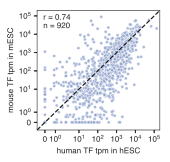

In [55]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(orth_tf_expr["mean_tpm_human"], 
           orth_tf_expr["mean_tpm_mouse"],
           color=sns.color_palette("Set2")[2], alpha=0.75, s=10, 
           linewidths=0.5, edgecolors="white")
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.75, 200000], [-0.75, 200000], "k", linestyle="dashed")
ax.set_xlim((-0.75, 200000))
ax.set_ylim((-0.75, 200000))

ax.set_xlabel("human TF tpm in hESC")
ax.set_ylabel("mouse TF tpm in mESC")

# annotate corr
no_nan = orth_tf_expr[(~pd.isnull(orth_tf_expr["mean_tpm_human"])) & 
                      (~pd.isnull(orth_tf_expr["mean_tpm_mouse"]))]
r, p = spearmanr(no_nan["mean_tpm_human"], no_nan["mean_tpm_mouse"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("TF_human_v_mouse_scatter.pdf", dpi="figure", bbox_inches="tight")

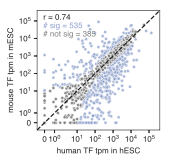

In [56]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

sig = orth_tf_expr[orth_tf_expr["sig"] == "sig"]
not_sig = orth_tf_expr[orth_tf_expr["sig"] == "not sig"]

ax.scatter(sig["mean_tpm_human"], 
           sig["mean_tpm_mouse"],
           color=sns.color_palette("Set2")[2], alpha=0.75, s=10, 
           linewidths=0.5, edgecolors="white")

ax.scatter(not_sig["mean_tpm_human"], 
           not_sig["mean_tpm_mouse"],
           color="gray", alpha=0.9, s=10, 
           linewidths=0.5, edgecolors="white")

ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.75, 400000], [-0.75, 400000], "k", linestyle="dashed")
ax.set_xlim((-0.75, 400000))
ax.set_ylim((-0.75, 400000))

ax.set_xlabel("human TF tpm in hESC")
ax.set_ylabel("mouse TF tpm in mESC")

# annotate corr
no_nan = orth_tf_expr[(~pd.isnull(orth_tf_expr["mean_tpm_human"])) & 
                      (~pd.isnull(orth_tf_expr["mean_tpm_mouse"]))]
r, p = spearmanr(no_nan["mean_tpm_human"], no_nan["mean_tpm_mouse"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "# sig = %s" % (len(sig)), ha="left", va="top", fontsize=fontsize, 
        color=sns.color_palette("Set2")[2],
        transform=ax.transAxes)
ax.text(0.05, 0.83, "# not sig = %s" % (len(not_sig)), ha="left", va="top", fontsize=fontsize, color="gray",
        transform=ax.transAxes)
fig.savefig("TF_human_v_mouse_scatter.w_sig_outline.pdf", dpi="figure", bbox_inches="tight")

In [57]:
sig.sort_values(by="log2FoldChange").head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig
609,ENSG00000166211,SPIC,0.000000,ENSMUSG00000004359,Spic,1124.515908,652.566766,-12.469269,1.448058,1.711926e-17,sig
673,ENSG00000119715,ESRRB,43.996854,ENSMUSG00000021255,Esrrb,53702.657586,31183.054223,-10.185911,0.165036,0.000000e+00,sig
973,ENSG00000189299,FOXR2,0.000000,ENSMUSG00000071665,Foxr2,150.704729,87.453455,-9.568900,1.471137,1.525192e-10,sig
835,ENSG00000127528,KLF2,11.847770,ENSMUSG00000055148,Klf2,9180.439620,5332.604600,-9.482722,0.303422,4.257018e-213,sig
586,ENSG00000123364,HOXC13,0.889697,ENSMUSG00000001655,Hoxc13,650.963466,378.117198,-9.250232,1.032184,7.831147e-19,sig


In [58]:
sig.sort_values(by="log2FoldChange", ascending=False).head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig
770,ENSG00000173917,HOXB2,1528.280669,ENSMUSG00000075588,Hoxb2,0.000000,639.187107,13.134547,1.341942,3.398850e-22,sig
769,ENSG00000120094,HOXB1,1325.536463,ENSMUSG00000018973,Hoxb1,0.000000,553.486068,12.926148,1.191905,6.269948e-27,sig
686,ENSG00000171956,FOXB1,2036.571489,ENSMUSG00000059246,Foxb1,0.551534,850.543715,11.703355,1.032161,2.652381e-29,sig
330,ENSG00000105996,HOXA2,379.114862,ENSMUSG00000014704,Hoxa2,0.000000,158.608368,11.122159,1.242702,8.701934e-19,sig
771,ENSG00000120093,HOXB3,792.250213,ENSMUSG00000048763,Hoxb3,0.650714,331.730116,10.342118,1.068165,9.486694e-22,sig


## 6. write files

In [59]:
orth_tf_expr.head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig
0,ENSG00000197921,HES5,101.620874,ENSMUSG00000048001,Hes5,0.000000,42.463063,9.220488,1.288307,1.707594e-12,sig
1,ENSG00000142611,PRDM16,127.168363,ENSMUSG00000039410,Prdm16,1160.183127,726.532277,-3.087431,0.291775,1.049818e-25,sig
2,ENSG00000078900,TP73,104.875666,ENSMUSG00000029026,Trp73,1094.785279,679.159979,-3.288922,0.188538,2.171432e-67,sig
3,ENSG00000173673,HES3,1260.850395,ENSMUSG00000028946,Hes3,6.791385,529.616567,7.618832,0.348308,4.031740e-105,sig
4,ENSG00000069812,HES2,30.322266,ENSMUSG00000028940,Hes2,11.737072,19.474793,1.493640,0.690207,3.923633e-02,not sig


In [60]:
orth_tf_expr[orth_tf_expr["gene_name_human"] == "ZNF524"]

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig


In [61]:
orth_tf_expr_f = "../../../data/03__rna_seq/04__TF_expr/orth_TF_expression.txt"
orth_tf_expr.to_csv(orth_tf_expr_f, sep="\t", index=False)

In [62]:
hESC_TFs = hESC_TFs[["index", "gene_name", "mean_tpm"]].drop_duplicates()
len(hESC_TFs)

1202

In [63]:
hESC_TF_expr_f = "../../../data/03__rna_seq/04__TF_expr/hESC_TF_expression.txt"
hESC_TFs.to_csv(hESC_TF_expr_f, sep="\t", index=False)

In [64]:
mESC_TFs = human_mouse_TFs[["gene_id_human", "gene_name_human", "gene_id_mouse", "gene_name_mouse", "mean_tpm_mouse"]].drop_duplicates()
len(mESC_TFs)

1082

In [65]:
mESC_TF_expr_f = "../../../data/03__rna_seq/04__TF_expr/mESC_TF_expression.txt"
mESC_TFs.to_csv(mESC_TF_expr_f, sep="\t", index=False)